/tmp/ipykernel_46533/2279335305.py:22: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql("SELECT park_score FROM postcodes WHERE park_score IS NOT NULL AND park_score > 0.3", conn)


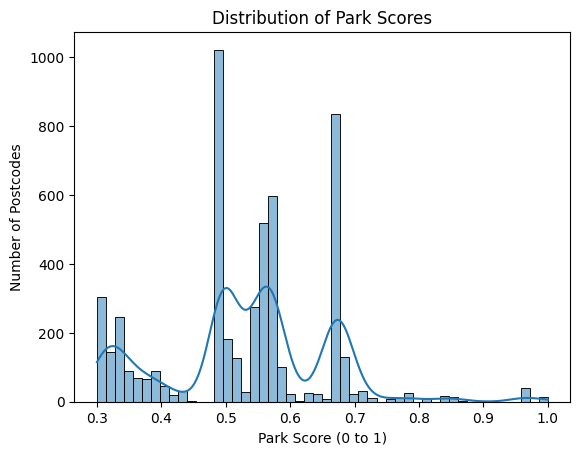

In [25]:
import psycopg2
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import yaml;

def load_config(path="../config/config.yaml"):
    with open(path, "r") as f:
        return yaml.safe_load(f)

config = load_config()
db = config['database']
conn = psycopg2.connect(
    dbname=db['dbname'],
    user=db['user'],
    password=db['password'],
    host=db['host'],
    port=db['port']
)

# Load data
df = pd.read_sql("SELECT park_score FROM postcodes WHERE park_score IS NOT NULL AND park_score > 0.3", conn)
conn.close()

# Plot histogram
sns.histplot(df['park_score'], bins=50, kde=True)
plt.title("Distribution of Park Scores")
plt.xlabel("Park Score (0 to 1)")
plt.ylabel("Number of Postcodes")
plt.show()


/tmp/ipykernel_46533/1173449804.py:23: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql("SELECT park_sqm FROM postcodes WHERE park_score IS NOT NULL", conn)


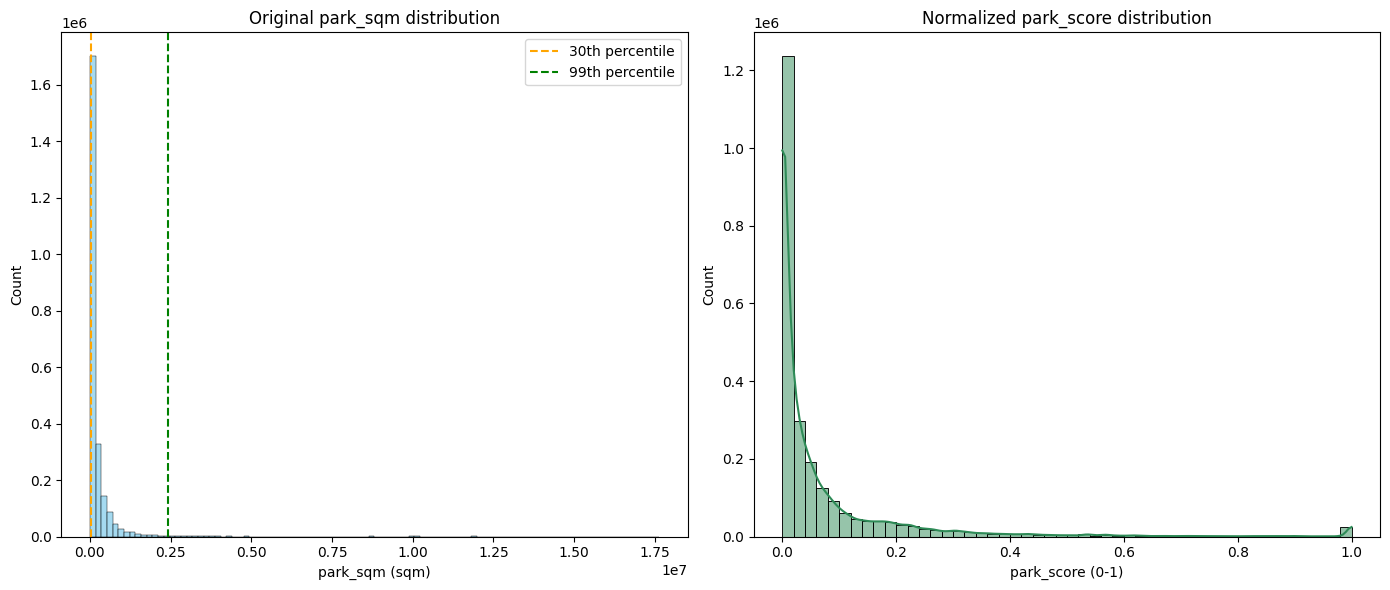

In [31]:
import psycopg2
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import yaml
import numpy as np

def load_config(path="../config/config.yaml"):
    with open(path, "r") as f:
        return yaml.safe_load(f)

config = load_config()
db = config['database']
conn = psycopg2.connect(
    dbname=db['dbname'],
    user=db['user'],
    password=db['password'],
    host=db['host'],
    port=db['port']
)

# Load data
df = pd.read_sql("SELECT park_sqm FROM postcodes WHERE park_score IS NOT NULL", conn)

park_sqm = df['park_sqm']

# Calculate percentiles
p10 = np.percentile(park_sqm, 30)
p90 = np.percentile(park_sqm, 99)

def normalize_with_clipping(x):
    if x <= p10:
        return 0.0
    elif x >= p90:
        return 1.0
    else:
        return (x - p10) / (p90 - p10)

# Apply normalization
df['park_score'] = park_sqm.apply(normalize_with_clipping)

# Plot original distribution
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(park_sqm, bins=100, kde=False, color='skyblue')
plt.title('Original park_sqm distribution')
plt.xlabel('park_sqm (sqm)')
plt.ylabel('Count')
plt.axvline(p10, color='orange', linestyle='--', label='30th percentile')
plt.axvline(p90, color='green', linestyle='--', label='99th percentile')
plt.legend()

# Plot normalized distribution
plt.subplot(1, 2, 2)
sns.histplot(df['park_score'], bins=50, kde=True, color='seagreen')
plt.title('Normalized park_score distribution')
plt.xlabel('park_score (0-1)')
plt.ylabel('Count')

plt.tight_layout()
plt.show()


conn.close()

/tmp/ipykernel_46533/1466492679.py:23: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql("SELECT park_sqm FROM postcodes WHERE park_score IS NOT NULL", conn)
/tmp/ipykernel_46533/1466492679.py:51: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


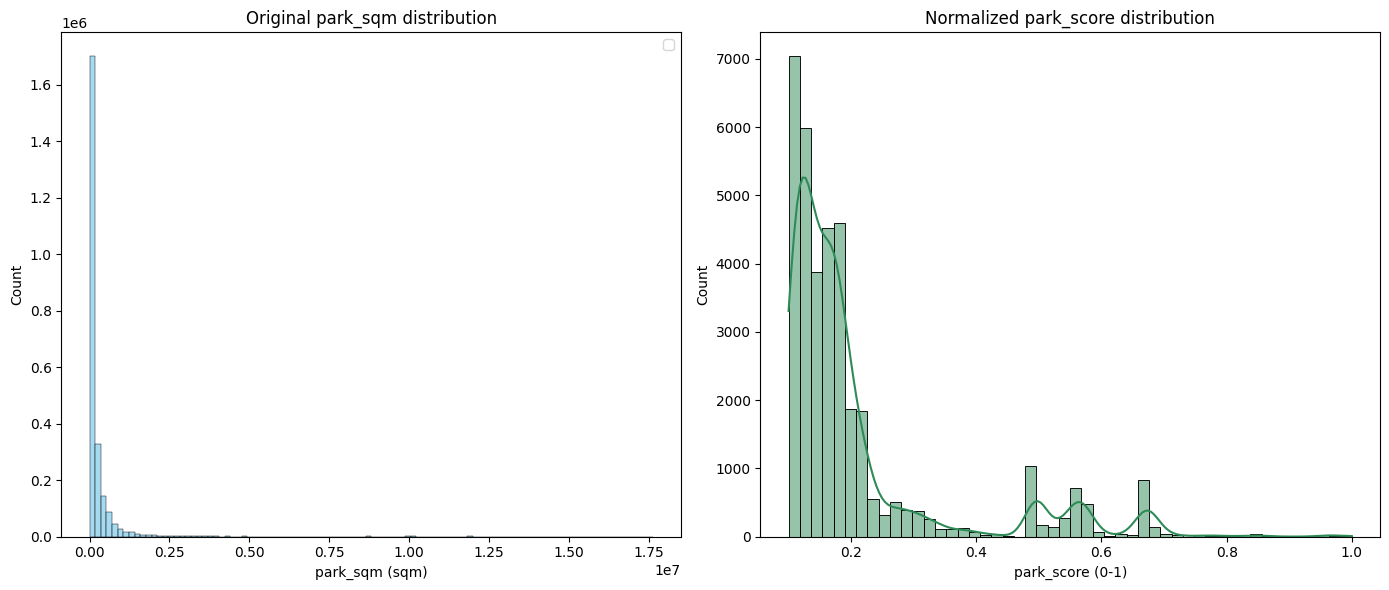

In [ ]:
import psycopg2
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import yaml
import numpy as np

def load_config(path="../config/config.yaml"):
    with open(path, "r") as f:
        return yaml.safe_load(f)

config = load_config()
db = config['database']
conn = psycopg2.connect(
    dbname=db['dbname'],
    user=db['user'],
    password=db['password'],
    host=db['host'],
    port=db['port']
)

# Load data
df = pd.read_sql("SELECT park_sqm FROM postcodes WHERE park_score IS NOT NULL", conn)

# Calculate percentiles
p10 = np.percentile(park_sqm, 30)
p90 = np.percentile(park_sqm, 100)

def normalize_with_clipping(x):
    if x <= p10:
        return 0.0
    elif x >= p90:
        return 1.0
    else:
        return (x - p10) / (p90 - p10)

# Apply normalization
df['park_score'] = park_sqm.apply(normalize_with_clipping)

# Apply normalization
score_no_zeros = df.loc[df['park_score'] > 0.4, 'park_score']

# Plot original distribution
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(park_sqm, bins=100, kde=False, color='skyblue')
plt.title('Original park_sqm distribution')
plt.xlabel('park_sqm (sqm)')
plt.ylabel('Count')
plt.legend()

# Plot normalized distribution
plt.subplot(1, 2, 2)
sns.histplot(score_no_zeros, bins=50, kde=True, color='seagreen')
plt.title('Normalized park_score distribution')
plt.xlabel('park_score (0-1)')
plt.ylabel('Count')

plt.tight_layout()
plt.show()


conn.close()